In [76]:
import cv2
import math
import numpy as np
import os
import matplotlib.pyplot as plt
from timeit import default_timer as time 
import tkinter as tk 
import datetime
from tkinter import filedialog

# Simple Downsampling

In [77]:
def simple_downsmpl(img ,srf):
  
    im_array = np.array(img)
    im_downsampled = im_array[::srf, ::srf, :]
    return im_downsampled

# Simple Upsampling --not working

In [91]:
def simple_upsmpl(img,srf):




    # Calculate the new dimensions of the image
    height, width, channels = img.shape
    new_height = int(height * srf)
    new_width = int(width * srf)

    # Resize the image using bilinear interpolation
    new_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
    
    # Save the interpolated image
    return new_img


# Floating window fo video input

In [79]:
def show_file_location(event):
    global file_path
    file_path = filedialog.askopenfilename()

root = tk.Tk()
root.geometry("250x150")

label = tk.Label(root, text="Select a file by \n clicking on a floating window \n \n NOTE --> Close the window after selection")
label.pack(pady=35)


label.bind("<Button-1>", show_file_location)

root.mainloop()

# Dark Channel Prior  -check pt1

In [80]:
def DCP(img,window):                                    
    #Spliting image into individual color components--> 
    R=img[:,:,2]
    G=img[:,:,1]
    B=img[:,:,0]
    h,w,c = img.shape
    
    #Flatening of image for loop jamming(reducing the number of loops) [other wise have to use 2 nested loop instead of 1]
    R1 = np.ravel(R)
    G1 = np.ravel(G)
    B1 = np.ravel(B)
    min_col_ch_img = np.empty(R1.size)    #[check pt1] #may be R1.size = R.size (check)
    
    for i in range(0,R.size): 
        min_col_ch_img[i] = min(B1[i],G1[i],R1[i])
    
    #Reshaping back to 2D image--> 
    min_col_ch_img = min_col_ch_img.reshape(h,w)
 
    kernel = np.ones((window,window), dtype = int)
    dark_ch = cv2.erode(min_col_ch_img,kernel)
    return dark_ch

# Global atmospheric light estimator (A)

In [81]:
def A_estimator(img,dark_ch):
    h,w,c = img.shape
    
    #Spliting image into individual color components--> 
    B = img[:,:,0]
    G = img[:,:,1]
    R = img[:,:,2]
    
    #Flatening of image for loop jamming(reducing the number of loops) [other wise have to use 2 nested loop instead of 1]
    B1 =B.ravel()
    G1 =G.ravel()
    R1 =R.ravel()
    
    #satcking flattened image to make 2d image in which [row 0] represents B coMponent ; [row 1] represents G component ;[row 2] represents R component 
    img1= np.vstack((B1,G1,R1))                
    dark_ch = dark_ch.ravel()

    #Descending order argsorting for 0.1% brightest pixel in dark_channel-->
    top_point_1_perc = dark_ch.argsort()[::-1]
    
    Atm_sum = np.zeros([3])
    for i in range(h*w//1000):
        Atm_sum[0]=Atm_sum[0] +img1[0][top_point_1_perc [i]]
    for i in range(h*w//1000):
        Atm_sum[1]=Atm_sum[1] +img1[1][top_point_1_perc [i]]
    for i in range(h*w//1000):
        Atm_sum[2]=Atm_sum[2] +img1[2][top_point_1_perc [i]] 
        
    Atm_sum = Atm_sum.reshape([1,3])  
    A = Atm_sum/(h*w//1000)
    return A

# Estimating trans estimator using Aerial perspective

In [82]:

def Trans_estimation(img, A, window, omega):
    #omega = 0.95
    img_temp = np.empty(img.shape, img.dtype)
    for i in range(3):
        img_temp[:,:,i] = img[:,:,i]/A[0,i]
    trans = 1 - omega*DCP(img_temp, window)
    return trans

# Guided filter

In [83]:
def Guided_filter(I,p,r,eps):
    mean_I = cv2.boxFilter(I, cv2.CV_64F, (r,r))
    mean_p = cv2.boxFilter(p, cv2.CV_64F, (r,r))
    corr_I = cv2.boxFilter(I*I, cv2.CV_64F, (r,r))
    corr_Ip = cv2.boxFilter(I*p, cv2.CV_64F, (r,r))
    
    var_I = corr_I - mean_I*mean_I
    cov_Ip = corr_Ip - mean_I*mean_p
    
    a = cov_Ip / (var_I + eps)
    b = mean_p - a*mean_I
    
    mean_a = cv2.boxFilter(a, cv2.CV_64F, (r,r))
    mean_b = cv2.boxFilter(b, cv2.CV_64F, (r,r))
    
    q = mean_a * I + mean_b
    
    return q

# Main dehazing function

In [84]:
def dehaze(img, r, n ,window):    
    #threshold
    t_0 = 0.1
    omega = 0.8
    eps = 0.001
    
    normalized_img = np.float64(img)/255
    dark_J = DCP(normalized_img, window)
    A = A_estimator(normalized_img, dark_J)
    t = Trans_estimation(normalized_img, A, r, omega)
    
    img_gs = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gs = np.float64(img_gs)/255
    t_fil = Guided_filter(img_gs,t,r*n,eps)
    
    t_thre = cv2.max(t_fil, t_0)
    J = np.empty(normalized_img.shape, normalized_img.dtype)
    for i in range(3):
        J[:,:,i] = (normalized_img[:,:,i]-A[0,i])/t_thre + A[0,i]
    
    return J

# Extracting frames from video 

In [85]:
file_path = file_path.replace("/", "\\")

vid_obj = cv2.VideoCapture(file_path)
fps = vid_obj.get(cv2.CAP_PROP_FPS)
no_of_frame = 0
while(True):
    success, frame = vid_obj.read()
    if success==False:
        break
    no_of_frame += 1
    print('Stored frame:', no_of_frame)
    #params = []
    #params.append(1)
    cv2.imwrite("C:\\Users\\qa284\\Desktop\\major project final code settings\\@NEW BEGININIGS\\testing\\extracted_frames\\frame" + "_%d.png" % no_of_frame, frame) #, params)
vid_obj.release()
# params is optional 



Stored frame: 1
Stored frame: 2
Stored frame: 3
Stored frame: 4
Stored frame: 5
Stored frame: 6
Stored frame: 7
Stored frame: 8
Stored frame: 9
Stored frame: 10
Stored frame: 11
Stored frame: 12
Stored frame: 13
Stored frame: 14
Stored frame: 15
Stored frame: 16
Stored frame: 17
Stored frame: 18
Stored frame: 19
Stored frame: 20
Stored frame: 21
Stored frame: 22
Stored frame: 23
Stored frame: 24
Stored frame: 25
Stored frame: 26
Stored frame: 27
Stored frame: 28
Stored frame: 29
Stored frame: 30
Stored frame: 31
Stored frame: 32
Stored frame: 33
Stored frame: 34
Stored frame: 35
Stored frame: 36
Stored frame: 37
Stored frame: 38
Stored frame: 39
Stored frame: 40
Stored frame: 41
Stored frame: 42
Stored frame: 43
Stored frame: 44
Stored frame: 45
Stored frame: 46
Stored frame: 47
Stored frame: 48
Stored frame: 49
Stored frame: 50
Stored frame: 51
Stored frame: 52
Stored frame: 53
Stored frame: 54


# Critical parameters

In [86]:
r=5
n=8
window = 11
srf =4 #srf is sampling rate factor

# Dehazing frames

In [92]:
x_fc=[]
y_time=[]



for f in range(1,no_of_frame+1):
    
    im_file = os.path.join('C:\\Users\\qa284\\Desktop\\major project final code settings\\@NEW BEGININIGS\\testing\\extracted_frames', 'frame_'+str(f)+'.png')
    img = cv2.imread(im_file)
    
    #timer starts 
    start = time()
    
      #downsampling frames -->
    img = simple_downsmpl(img,srf)
   
    J = dehaze(img, r, n,window)

        
    
    
    #timer ends 
    
    
    im_file = os.path.join('C:\\Users\\qa284\\Desktop\\major project final code settings\\@NEW BEGININIGS\\testing\\dehazed_frames', 'frame_'+str(f)+'.png')
    cv2.imwrite(im_file, simple_upsmpl(J*255,srf))
    end = time()
    
    elpsd_time =end - start
    x_fc.append(f)
    y_time.append(elpsd_time)
    print('Dehazed frame:',f ,"\t | \t Time_taken:",y_time[f-1],"seconds")
    print("--------------------------------------------------------------------------")

Dehazed frame: 1 	 | 	 Time_taken: 0.515323200000239 seconds
--------------------------------------------------------------------------
Dehazed frame: 2 	 | 	 Time_taken: 0.49534749999975247 seconds
--------------------------------------------------------------------------
Dehazed frame: 3 	 | 	 Time_taken: 0.511587899999995 seconds
--------------------------------------------------------------------------
Dehazed frame: 4 	 | 	 Time_taken: 0.49068020000004253 seconds
--------------------------------------------------------------------------
Dehazed frame: 5 	 | 	 Time_taken: 0.5678452999995898 seconds
--------------------------------------------------------------------------
Dehazed frame: 6 	 | 	 Time_taken: 0.5536591000000044 seconds
--------------------------------------------------------------------------
Dehazed frame: 7 	 | 	 Time_taken: 0.552484800000002 seconds
--------------------------------------------------------------------------
Dehazed frame: 8 	 | 	 Time_taken: 0.55528

# Frame assembling to make dehazed video 

In [88]:
file_path = file_path.replace("/", "\\")
vid_obj = cv2.VideoCapture(file_path)
fps = vid_obj.get(cv2.CAP_PROP_FPS)
print(fps)

24.0


In [89]:
  
fps = vid_obj.get(cv2.CAP_PROP_FPS)
demo = cv2.imread('C:\\Users\\qa284\\Desktop\\major project final code settings\\@NEW BEGININIGS\\testing\\dehazed_frames\\frame_1.png')
demo = np.min(demo, axis = 2)
size = demo.shape
size = (size[1],size[0])
print('Assembling dehazed frames to make up Video ==>')
cap = cv2.VideoWriter("C:\\Users\\qa284\\Desktop\\major project final code settings\\@NEW BEGININIGS\\testing\\dehazed_video.avi",cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'), fps, size)
for i in range(1,no_of_frame+1):
    im_file = os.path.join('C:\\Users\\qa284\\Desktop\\major project final code settings\\@NEW BEGININIGS\\testing\\dehazed_frames', 'frame_'+str(i)+'.png')
    img = cv2.imread(im_file)
    cap.write(img)
cap.release()


Assembling dehazed frames to make up Video ==>


# Timing plots and other details 

In [45]:
print(x_fc)
print(y_time)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]
[1.6906719000000408, 1.6500405999999543, 1.5842437000000018, 1.5810628000000406, 1.578027700000007, 1.704000600000029, 1.734831999999983, 1.7260602000000063, 1.5846601000000078, 1.6336273000000006, 1.6116966999999818, 1.595376299999998, 1.6466764000000467, 1.720835299999976, 1.6098407999999722, 1.63420229999997, 1.6618376999999782, 1.623000100000013, 1.9476311999999893, 1.6603915999999685, 1.6919144000000301, 1.6758231000000023, 1.6392002000000048, 1.7078697000000034, 1.8091425999999728, 1.6270913000000178, 1.6157784999999762, 1.6526664000000437, 1.8066418000000226, 1.7380955000000426, 1.6294002999999861, 1.5990004999999883, 1.5886844999999994, 1.5748346999999967, 1.5981090000000222, 1.6525204000000144, 1.7833186999999953, 1.9095848000000046, 1.7425693999999794, 1.8349049000000264,

----------------------------------------------------------------------------------
Frames per second of video--> 24.0
----------------------------------------------------------------------------------
video duration [hh:mm:ss]--> 0:00:02
----------------------------------------------------------------------------------
Total number of frames in video: 54.0
----------------------------------------------------------------------------------
Total time for dehazing video: 94.51661960000007
----------------------------------------------------------------------------------
Average time for dehazing per frame: 1.7503077703703716
----------------------------------------------------------------------------------
maximum processing time for a frame 2.1863210999999865
----------------------------------------------------------------------------------
minimum processing time for a frame 1.5748346999999967
----------------------------------------------------------------------------------


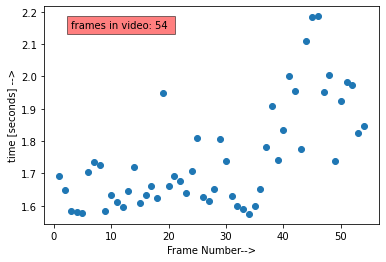

In [46]:
print("----------------------------------------------------------------------------------")
frames = vid_obj.get(cv2.CAP_PROP_FRAME_COUNT)
fps = vid_obj.get(cv2.CAP_PROP_FPS)
seconds = round(frames / fps)
video_time = datetime.timedelta(seconds=seconds)
print(f"Frames per second of video--> {fps}")
print("----------------------------------------------------------------------------------")
print(f"video duration [hh:mm:ss]--> {video_time}")
print("----------------------------------------------------------------------------------")
print("Total number of frames in video:",frames)
print("----------------------------------------------------------------------------------")
print("Total time for dehazing video:",sum(y_time))
print("----------------------------------------------------------------------------------")
print("Average time for dehazing per frame:",sum(y_time)/len(y_time))
print("----------------------------------------------------------------------------------")
print("maximum processing time for a frame", max(y_time) )
print("----------------------------------------------------------------------------------")
print("minimum processing time for a frame", min(y_time) )
print("----------------------------------------------------------------------------------")
# print(y_time)
# print("----------------------------------------------------------------------------------")
# print(res)
# print("----------------------------------------------------------------------------------")
# print(x_fc)
# print("----------------------------------------------------------------------------------")
# print(len(y_time))
# print("----------------------------------------------------------------------------------")
plt.scatter(x_fc,y_time)
plt.ylabel("time [seconds] -->")
plt.xlabel("Frame Number-->")
plt.text(3,2.15 , f'frames in video: { len(y_time) } ' , bbox=dict(facecolor='red', alpha=0.5))
plt.show()